## Introduction

In this notebook we'll just try to model the lobbying data, ignoring the stock data.

In [1]:
from importlib import reload

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import pmdarima
from statsmodels.graphics.tsaplots import plot_acf

# Silencing a Pandas warning about date parsing
import warnings
warnings.filterwarnings("ignore", message="Could not infer format")

pd.set_option('max_colwidth', 400)

In [2]:
from scripts.data_extraction import get_all_lobbying_data
lobbying_train = get_all_lobbying_data()

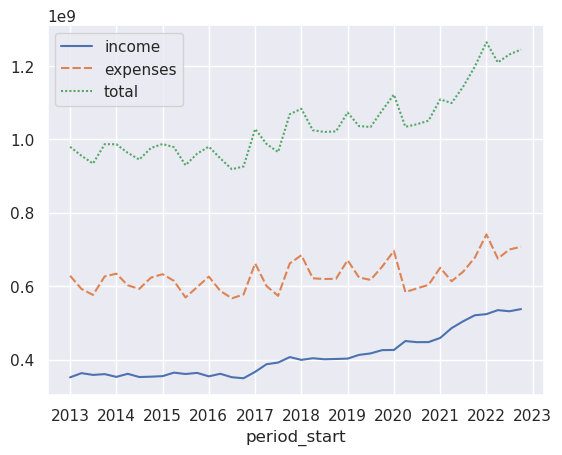

In [3]:
all_totals = lobbying_train.groupby("period_start")[["income", "expenses"]].sum()
all_totals["total"] = all_totals.sum(axis=1)
sns.lineplot(all_totals);

Some features of this graph to observe:
1. Lobbying expenses (expenditure by organizations lobbying on their own behalf) outweigh lobbying income (payments by organizations to lobbyists to lobby for them) by a factor of about 2.
2. Expenses are seasonal, peaking in the first quarter of every year. This seasonality apparently doesn't affect income, so it's presumably not related to the legislative calendar. My guess is that it's related to businesses' budgetary or tax calendars.
3. Both income and expenses, but particularly income, have an upwards trend starting in 2017. This may be related to Trump's election, though it continues unabated through the Biden presidency.

## An example: Apparel (APP)

In [4]:
filings = pd.read_csv("lobbying_data/by_issue_code/filings_APP.csv", parse_dates=["period_start", "period_end", "dt_posted"])
filings = filings[filings.period_start.dt.year < 2023]

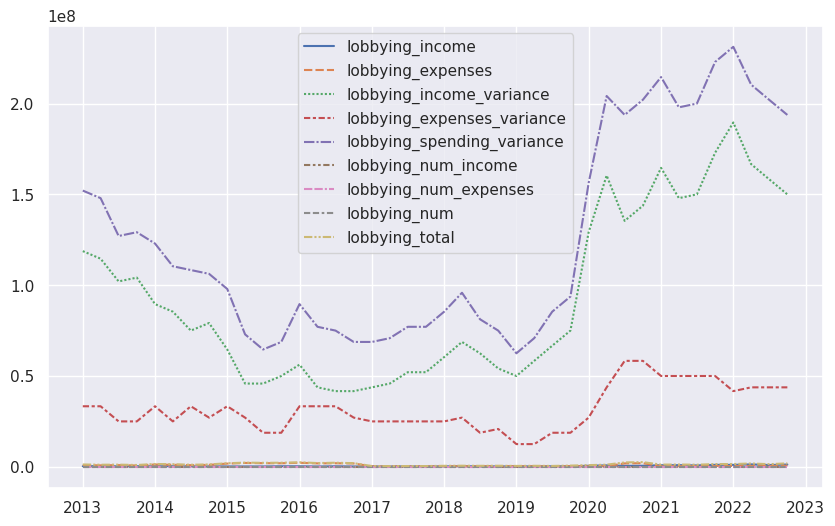

In [5]:
from scripts.data_extraction import lobbying_totals

plt.figure(figsize=(10,6))
sns.lineplot(lobbying_totals("APP"));

Each lobbying disclosure lists either "income" or "expenses", with "income" reported if a lobbying firm is hired, and "expenses" if an organization or individual is lobbying on their own behalf. The plot above has three interesting features: a sharp dip in expenses at the beginning of 2017, a gradual increase in income starting in 2020, and a large spike in expenses from Q3-Q4 2020. The total number of filings also jumps in 2020, as the chart below shows.

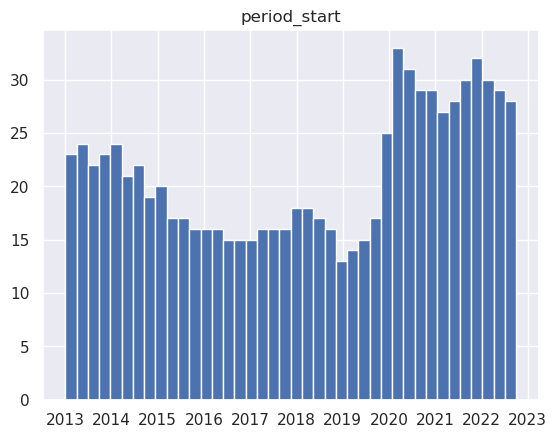

In [6]:
filings.hist("period_start", bins=filings.period_start.nunique());

From examining the filings, a clear concern before 2017 was the proposed Trans-Pacific Partnership (TPP), which would have increased competition for US textile exports [1]. Trump made withdrawal from TPP a major campaign proposal, and withdrew shortly after his inauguration in January 2017. As the plots below show, a large proportion of pre-2017 lobbying expenses was TPP related.

[1] Platzer, Michael D., [US Textile Manufacturing and the Proposed Trans-Pacific Partnership Agreement](https://sgp.fas.org/crs/misc/R44610.pdf), Congressional Research Service (2016).

array([[<Axes: title={'center': 'period_start'}>]], dtype=object)

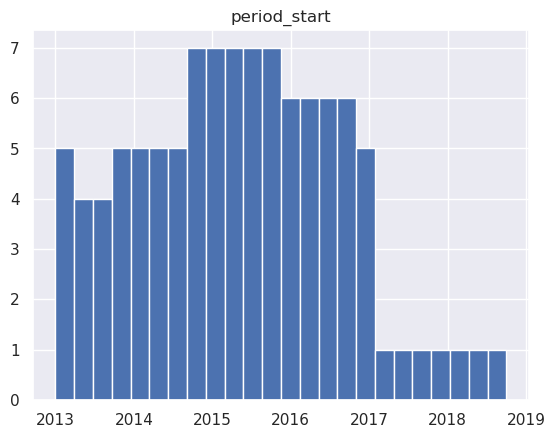

In [7]:
tpp = filings[
    filings.lobbying_description.str.contains("Trans-Pacific-Partnership", case=False)
    | filings.lobbying_description.str.contains("TPP")
]
tpp.hist("period_start", bins=tpp.period_start.nunique())


<Axes: >

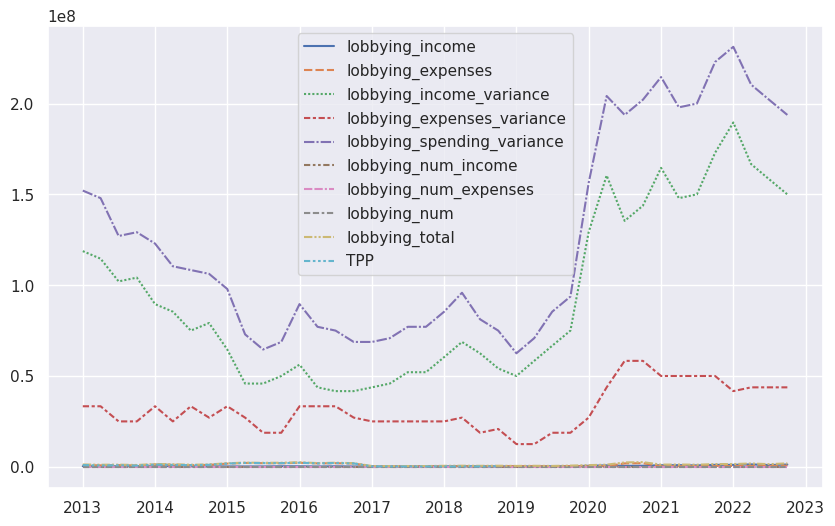

In [8]:
plt.figure(figsize=(10,6))
sns.lineplot(lobbying_totals("APP").merge(
    pd.DataFrame({"TPP": tpp.groupby("period_start")[["income", "expenses"]]
                  .sum().sum(axis=1)}),
    how="outer", left_index=True, right_index=True
))

All records after January 2017 mentioning TPP come from the American Apparel & Footwear Association, which was apparently reusing an out-of-date lobbying form.

In [9]:
from scripts.data_extraction import print_lobbying_summary
print_lobbying_summary(tpp.iloc[-7])

2017-04-01
Registrant:  AMERICAN APPAREL & FOOTWEAR ASSOCIATION
Client:  AMERICAN APPAREL & FOOTWEAR ASSOCIATION
Issue codes lobbied:  TRD, DEF, APP, TAR
Expenses:  168225.0
Discussions with Congress and Administration (including USTR, Commerce, ITC, Labor, State, Agriculture, the SEC, and Customs):
oon modernization of North American Free Trade Agreement (NAFTA).
oon implementation of free trade agreements (FTAs).
oon consideration of pending free trade agreements, including disposition of Trans-Pacific Partnership (TPP)
oon negotiation of new trade agreements, including Trans-Atlantic Trade and Investment Partnership (T-TIP), International Services Agreement (ISA), and Trade Facilitation agreement. Issues discussed include:
&#239;‚&#167;rules of origin
&#239;‚&#167;duties
&#239;‚&#167;customs provisions
&#239;‚&#167;IPR provisions
&#239;‚&#167;Regulatory harmonization
&#239;‚&#167;Transportation measures
&#239;‚&#167;Government procurement.
&#239;‚&#167;Port maintenance issues
oon th

The expenses spike in 2020 is due to two huge (~$1.5M) expenditures by Walmart. Walmart often has high lobbying expenditures, but rarely lobbies the APP issue code. One of the disclosures is below; the APP code is presumably related to "foreign assistance programs for global garment workers".

In [10]:
print_lobbying_summary(filings.iloc[611])

2020-10-01
Registrant:  WALMART INC.
Client:  WALMART INC
Issue codes lobbied:  TRD, DIS, HCR, ENV, IMM, TAX, VET, LAW, CSP, FOO, LBR, APP
Expenses:  1560000.0
Discussions regarding trade enforcement actions and tariff proposals by the Administration
Discussions regarding the U.S.-UK FTA
Discussions regarding Section 201 investigations into seasonal produce

Discussions related to the company's response to the Novel Corona Virus (Covid-19) pandemic.

Discussions include policy guidance related to transportation, supply chain, investments in associates and commitment to hiring, and trade in connection with COVID-19.

Discussions regarding employees benefits innovations
Discussions related to COVID-19 testing, vaccine administration and preparation including prioritization recommendations

Discussions regarding corporate sustainability initiatives

Discussions regarding support for legislative solution for Deferred Action for Childhood Arrivals (DACA)

Discussions related to H.R.4849, Up

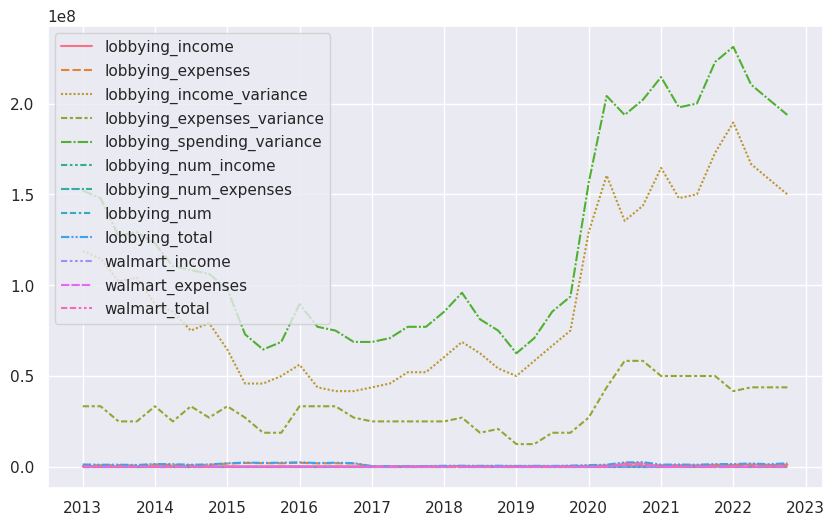

In [11]:
walmart_totals = filings[
    (filings.registrant.str.contains("Walmart", case=False))
    | (filings.client.str.contains("Walmart", case=False))
].groupby("period_start")[["income", "expenses"]].sum()
walmart_totals["total"] = walmart_totals.sum(axis=1)
walmart_totals.columns=["walmart_income", "walmart_expenses", "walmart_total"]

plt.figure(figsize=(10,6))
ax = sns.lineplot(lobbying_totals("APP").merge(
    walmart_totals, how="outer", left_index=True, right_index=True
).fillna(0))
sns.move_legend(ax, "upper left")

Now, since the above filing reflects lobbying towards 12 codes, one could argue that it's not really reflective of \\$1,560,000 spent on apparel lobbying. As a rough estimate, we could imagine that the \\$1,560,000 is distributed equally among the 12 codes. More generally, if a company spends $\$D$ to lobby on $N$ codes, then we could say they've spent $\$D/N$ per code. Note that this generates a spending signal for each code whose sum is the total lobbying expenditure.

Modifying the totals for APP using this normalization makes the Walmart spike disappear:

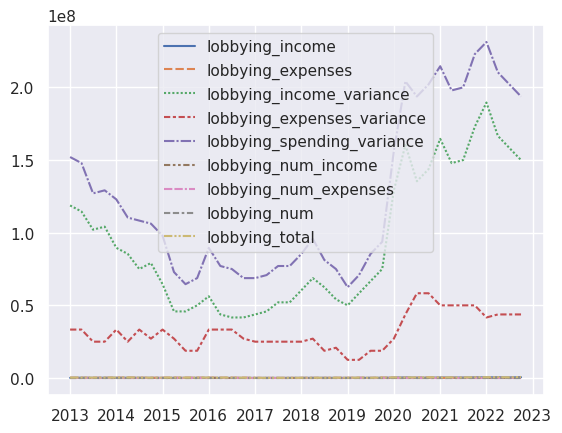

In [12]:
sns.lineplot(lobbying_totals("APP", adjust_for_num_codes=True));

The increase in lobbying income starting in 2020 is harder to understand (and seems to reflect broader trends in lobbying). A number of lobbying firms begin spending more money at this point.

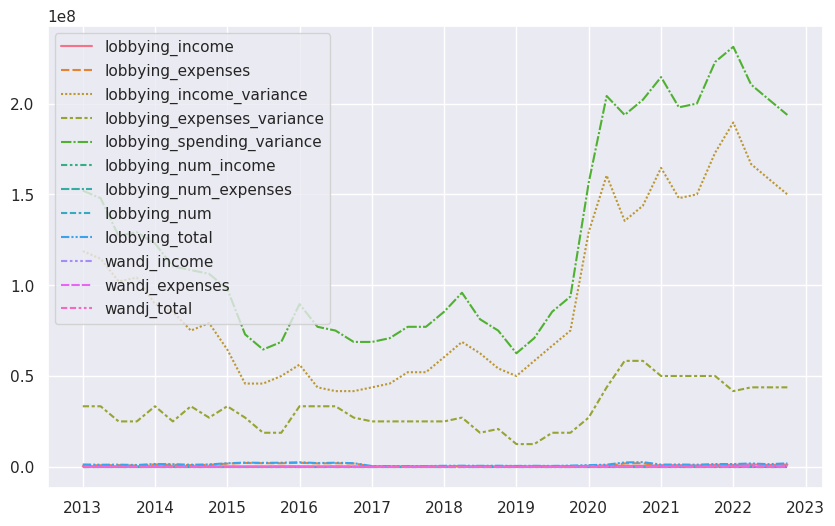

In [13]:
wandj_totals = filings[
    (filings.registrant.str.contains("williams and jensen", case=False))
    | (filings.client.str.contains("williams and jensen", case=False))
].groupby("period_start")[["income", "expenses"]].sum()
wandj_totals["total"] = wandj_totals.sum(axis=1)
wandj_totals.columns=["wandj_income", "wandj_expenses", "wandj_total"]

plt.figure(figsize=(10,6))
ax = sns.lineplot(lobbying_totals("APP").merge(
    wandj_totals, how="outer", left_index=True, right_index=True
).fillna(0))
sns.move_legend(ax, "upper left")

In [14]:
filings[
    # (filings.period_start >= pd.to_datetime("2020")) &
    (filings.income > 0)
].sort_values(by="income", ascending=False)[["registrant", "client", "income", "period_start"]].head(30)

,registrant,client,income,period_start
774,"WILLIAMS AND JENSEN, PLLC",TOM JAMES COMPANY,460000.0,2022-04-01
628,"WILLIAMS AND JENSEN, PLLC",TOM JAMES COMPANY,200000.0,2021-01-01
665,"WILLIAMS AND JENSEN, PLLC",TOM JAMES COMPANY,170000.0,2021-04-01
830,"WILLIAMS AND JENSEN, PLLC",W DIAMOND GROUP CORPORATION,140000.0,2022-10-01
291,MS. MISSY BRANSON,GLEN RAVEN INC 1831 NORTH PARK AVENUE GLEN RAVEN NC 27217,140000.0,2016-07-01
835,"VENTURE GOVERNMENT STRATEGIES, LLC (FKA HOBART HALLAWAY & QUAYLE VENTURES, LLC)",SHEIN TECHNOLOGY LLC,140000.0,2022-10-01
828,"WILLIAMS AND JENSEN, PLLC","HICKEY FREEMAN TAILORED CLOTHING, INC",130000.0,2022-10-01
829,"WILLIAMS AND JENSEN, PLLC",J.A. APPAREL CORP.,130000.0,2022-10-01
675,SQUIRE PATTON BOGGS,CINTAS CORPORATION,120000.0,2021-07-01
530,"WILLIAMS AND JENSEN, PLLC",GITMAN AND COMPANY,120000.0,2020-04-01


In [15]:
print_lobbying_summary(filings.iloc[717])

2021-10-01
Registrant:  WILLIAMS AND JENSEN, PLLC
Client:  TOM JAMES COMPANY
Issue codes lobbied:  APP, TRD, MAN
Income:  80000.0
Issues related to personal protective equipment; funding for PPE and buy American provisions (H.R. 3684; S. 1260; H.R. 1466; S. 869; American Recovery Act (H.R, 1319); Endless Frontier Act).

Duties on cotton and wool fabrics; 2018 Farm Bill implementation;  federal initiatives to support domestic manufacturing. Duties on Fabrics for PPEs.

Assistance for apparel and textile manufacturers.


<Axes: xlabel='period_start'>

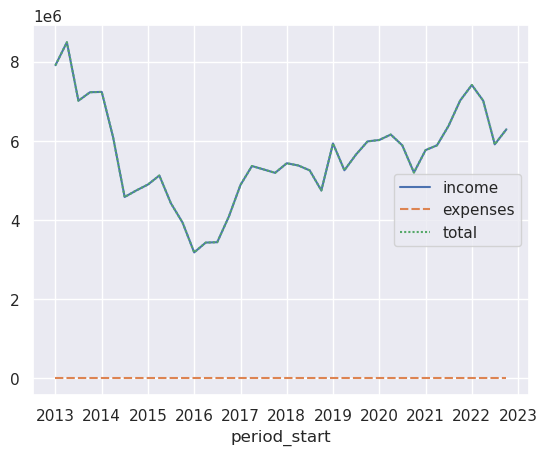

In [16]:
wandj = lobbying_train[lobbying_train.registrant.str.contains("squire patton boggs", case=False)]
wandj_totals = wandj.groupby("period_start")[["income", "expenses"]].sum()
wandj_totals["total"] = wandj_totals.sum(axis=1)
sns.lineplot(wandj_totals)
# wandj.period_start.hist(bins=wandj.period_start.nunique())

## Visualizing the per-code lobbying signals

There are a few phenomena we want to understand before modeling:

1. Is the seasonality in lobbying expenses reflected in all codes?
2. Is the trend in lobbying expenses and income starting in 2017 reflected in all codes?
3. Does the income-expenses ratio vary over time or from code to code?
4. Are different codes correlated with each other? Can spending in some codes be used as a leading predictor for spending in other codes?

In [17]:
from pathlib import Path
codes = [x.stem[-3:] for x in Path("lobbying_data/by_issue_code/").glob("*.csv")]

In [18]:
from scripts.data_extraction import lobbying_totals
for code in codes:
    code_totals = lobbying_totals(code, adjust_for_num_codes=True)
    code_totals.columns = [code + "_" + x for x in code_totals.columns]
    all_totals = pd.merge(all_totals, code_totals, left_index=True, right_index=True)


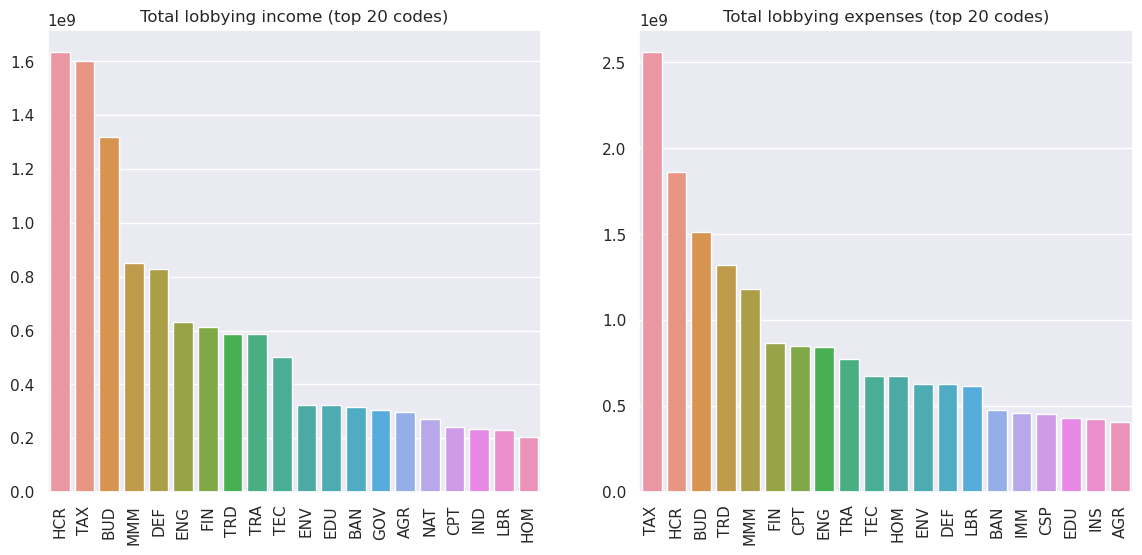

In [19]:
income_cols = [x for x in all_totals.columns if x.endswith("income")]
expenses_cols = [x for x in all_totals.columns if x.endswith("expenses")]
total_cols = [x for x in all_totals.columns if x.endswith("total")]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
income_tots = all_totals[income_cols].sum().sort_values(ascending=False)[1:21]
sns.barplot(x=[s[:3] for s in income_tots.index], y=income_tots.values, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation="vertical");
axs[0].set_title("Total lobbying income (top 20 codes)");

expenses_tots = all_totals[expenses_cols].sum().sort_values(ascending=False)[1:21]
sns.barplot(x=[s[:3] for s in expenses_tots.index], y=expenses_tots.values, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation="vertical");
axs[1].set_title("Total lobbying expenses (top 20 codes)");

In [20]:
len(codes)

79

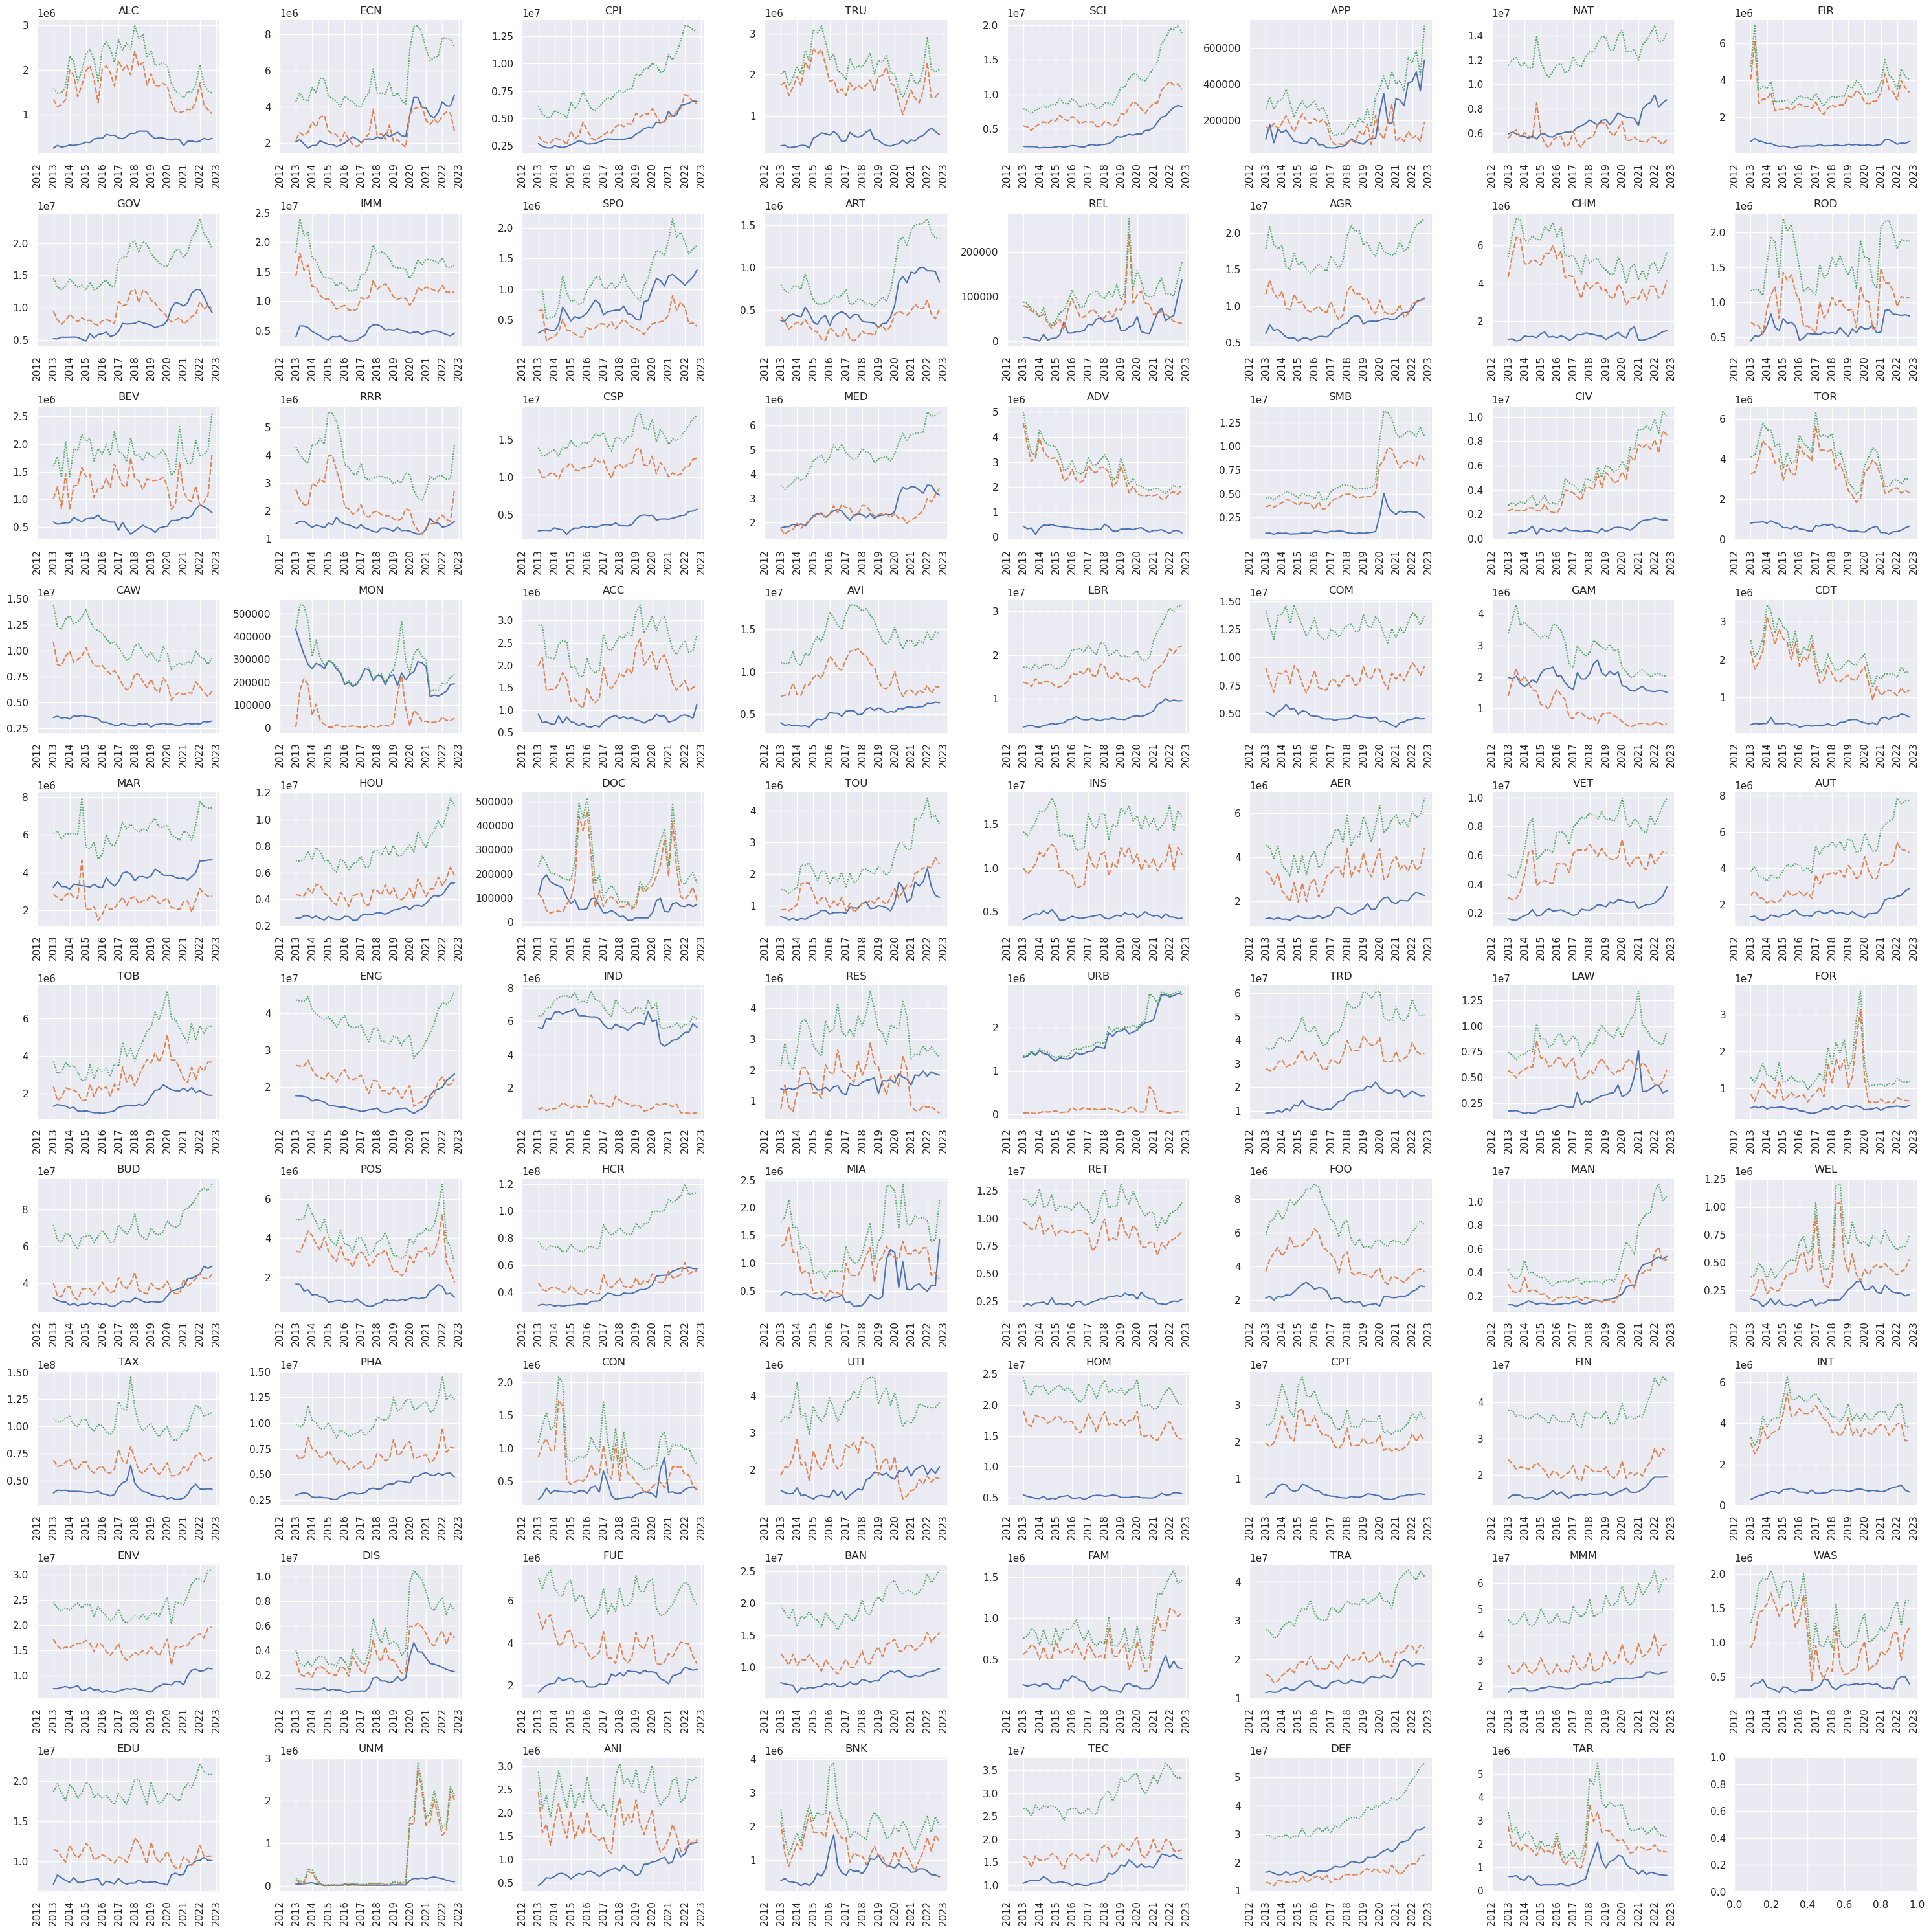

In [23]:
fig, axs = plt.subplots(10, 8, figsize=(30, 30))
axs = axs.flatten()

expenses_tots = all_totals[expenses_cols].sum().sort_values(ascending=False)[1:]
for i, code in enumerate(codes):
    code = code[:3]
    sns.lineplot(all_totals[[f"{code}_lobbying_income", f"{code}_lobbying_expenses", f"{code}_lobbying_total"]], ax=axs[i], legend=False)
    axs[i].set_title(code)
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation="vertical")
    axs[i].set_xlabel(None)
    
plt.tight_layout()

This image is quite large -- you may want to open it in another tab. Here are some observations we can make:
1. Many of the codes show a yearly cycle in expenses that peaks in the first quarter. Of the top 30 codes, the ones for which this cycle is not clearly present are DEF (defense), IMM (immigration), and CSP (consumer issues/safety/protection).
2. Many of the codes show similar income and expenses behavior, with income looking like a scaled, smoothed version of expenses. The relationship becomes less clear as the amount of spending decreases: for example, FOR (foreign relations) and AVI (aviation) show large spikes in expenses that aren't matched by increases in income.
3. Income is typically around half expenses, but in some less-lobbied codes like RES (real estate), APP (apparel), and TOU (tourism), the ratio is closer to 1:1. URB (urban development), IND (Indian affairs), and DEF (defense) have consistently higher income than expenses (related to the fact that these are essentially state, rather than corporate, projects). The same is true of NAT (natural resources) after 2020.
4. Many, but not all, of the codes show an upwards trend in both income and expenses. Of the top 20 codes, HCR (health care), MMM (Medicare/Medicaid), TRA (transportation), TEC (technology), DEF (defense), LBR (labor), BAN (banking), CSP (consumer safety), and AGR (agriculture) show a consistent upwards trend. BUD (budget), FIN (financial institutions), ENG (energy), ENV (environment), and EDU (education) show a sharper upwards trend starting around 2020. These trends could probably be removed by differencing the data.
5. A few historical events are immediately visible: the 2020 spike in UNM (unemployment) lobbying is due to COVID; the 2021 spike in FAM (family issues) is probably related to the appearance of the *Dobbs* case, which overturned the federal right to abortion, before the Supreme Court.

## The income-expenses ratio

Some examples of the relationship between income and expenses:

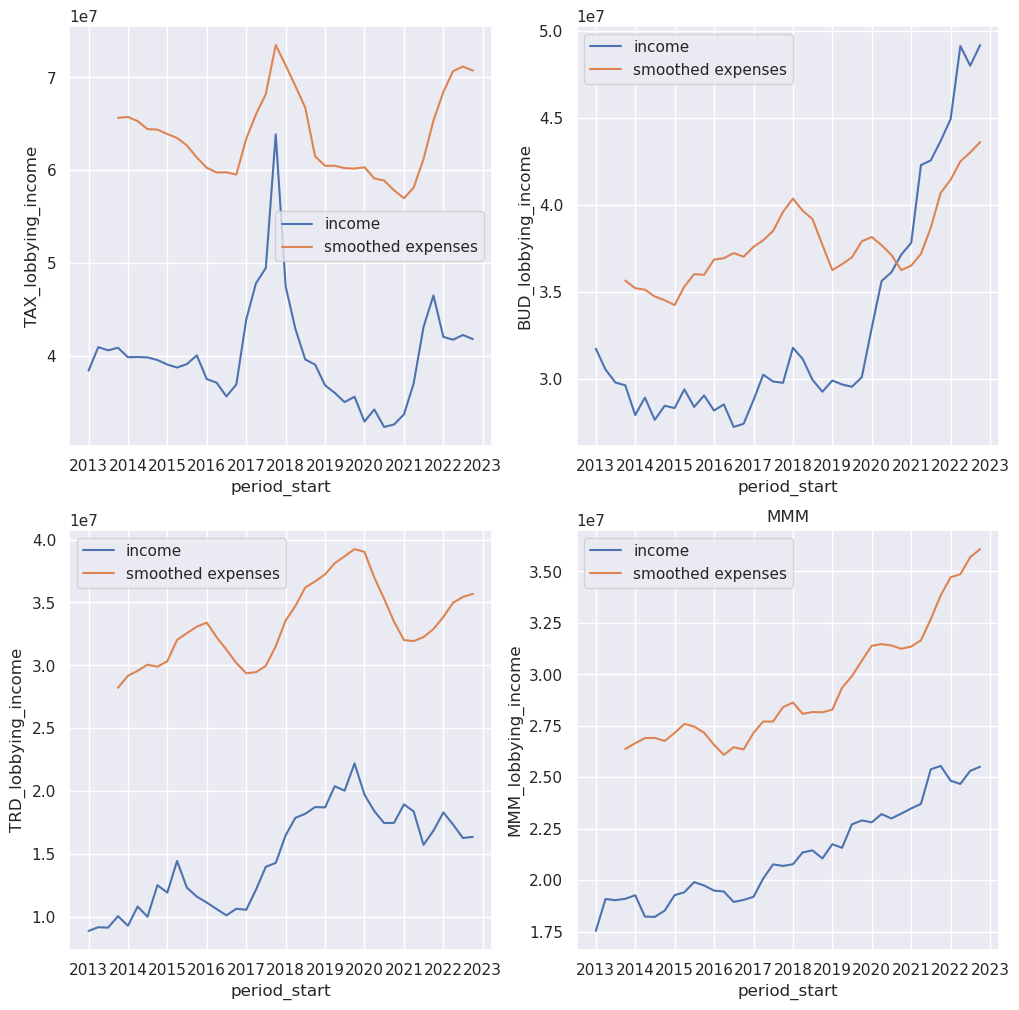

In [24]:
four_codes = ["TAX", "BUD", "TRD", "MMM"]
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()
for i, code in enumerate(four_codes):
    sns.lineplot(all_totals[f"{code}_lobbying_income"], label="income", ax=axs[i]);
    sns.lineplot(all_totals[f"{code}_lobbying_expenses"].rolling(4).mean(), label="smoothed expenses", ax=axs[i]);
    plt.title(code);

In [26]:
for code in codes:
    all_totals[f"{code}_ratio"] = all_totals[f"{code}_lobbying_expenses"] / all_totals[f"{code}_lobbying_income"]
    
ratio_cols = [x for x in all_totals.columns if x.endswith("ratio")]
col_sums = pd.DataFrame(index=codes, columns=["income", "expenses"])
for code in codes:
    col_sums.loc[code, "income"] = all_totals[f"{code}_lobbying_income"].sum()
    col_sums.loc[code, "expenses"] = all_totals[f"{code}_lobbying_expenses"].sum()


Correlation between income and expenses: 0.941


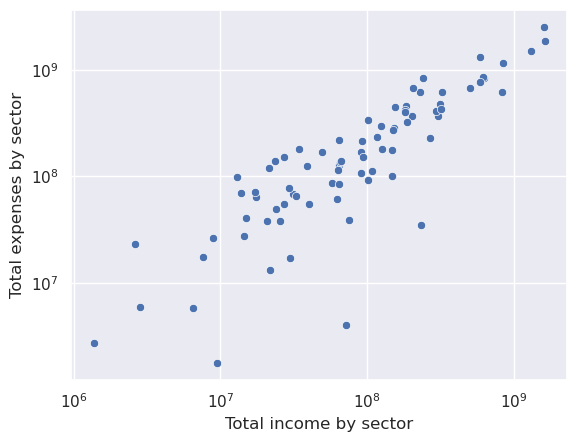

In [27]:
sns.scatterplot(col_sums, x="income", y="expenses")
plt.xlabel("Total income by sector")
plt.ylabel("Total expenses by sector")
plt.xscale("log")
plt.yscale("log");
print(f"Correlation between income and expenses: {col_sums.corr().iloc[0, 1]:.3f}")

Text(0.5, 1.0, 'Expenses to income ratio by sector')

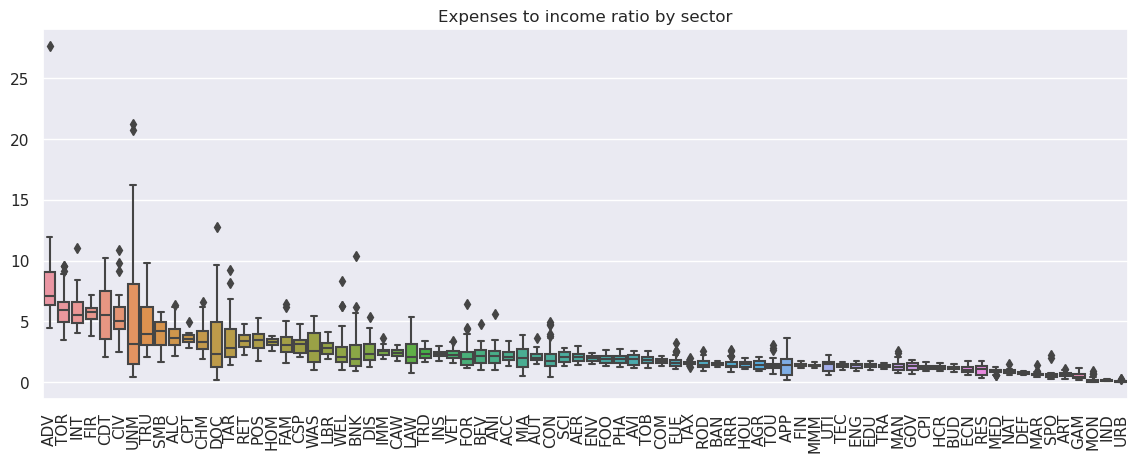

In [28]:
# This plot doesn't include REL (religion)
ratio_cols_fixed = all_totals[ratio_cols].mean().sort_values(ascending=False).index[1:]
plt.figure().set_figwidth(14)
sns.boxplot(all_totals[ratio_cols_fixed])
plt.xticks(ticks=plt.gca().get_xticks(), labels=[x[:3] for x in ratio_cols_fixed], rotation="vertical");
plt.title("Expenses to income ratio by sector")

REL (religion) had to be excluded since it gave a really high number here. This was basically due to one outlier instance by Ascension Health.

<Axes: xlabel='period_start', ylabel='adjusted_expenses'>

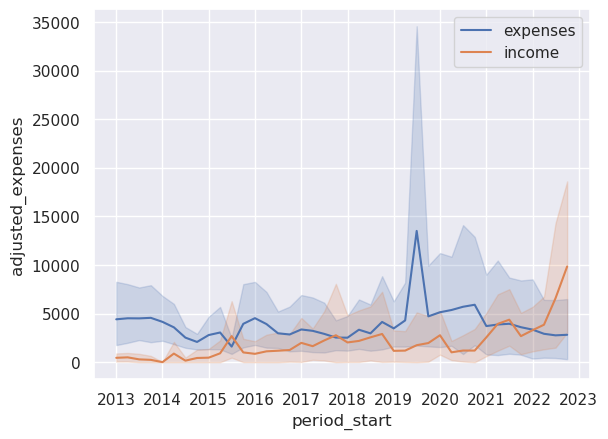

In [29]:
rel_lobbying = lobbying_train[lobbying_train.issue_codes.str.contains("REL")].copy()
rel_lobbying["num_codes"] = rel_lobbying["issue_codes"].map(lambda x: len(eval(x)))
rel_lobbying["adjusted_income"] = rel_lobbying["income"] / rel_lobbying["num_codes"]
rel_lobbying["adjusted_expenses"] = rel_lobbying["expenses"] / rel_lobbying["num_codes"]
sns.lineplot(rel_lobbying, x=rel_lobbying.period_start, y=rel_lobbying["adjusted_expenses"], label="expenses")
sns.lineplot(rel_lobbying, x=rel_lobbying.period_start, y=rel_lobbying["adjusted_income"], ax=plt.gca(), label="income")

In [30]:
from scripts.data_extraction import print_lobbying_summary
rel_lobbying.period_start = pd.to_datetime(rel_lobbying.period_start)
row = rel_lobbying[rel_lobbying.period_start.dt.year == 2019].sort_values(by="adjusted_expenses", ascending=False).iloc[0]
print_lobbying_summary(row)

2019-07-01
Registrant:  ASCENSION HEALTH ALLIANCE D/B/A ASCENSION
Client:  ASCENSION HEALTH ALLIANCE D/B/A ASCENSION
Issue codes lobbied:  PHA, IMM, VET, HCR, MMM, REL
Expenses:  1100000.0
Affordable prescription drugs, 340B program, drug shortages

Supported maintaining the current definition of Public Charge to ensure continued access to Medicaid and other federal assistance programs.

Implementation of the Mission Act

Affordable prescription drugs, 340B Program, HR985 FAST Generics Act of 2019, Appropriate and accurate payment for healthcare, Site Neutral payment policies, S. 1895 - Lower Health Care Costs Act, S. 340 - CREATES Act, H.R. 987 - Strengthening Health Care and Lowering Prescription Drug Costs Act, S. 1391 - Fair Accountability and Innovative Research Drug Pricing Act of 2019, Surprise billing: S. 1531 - Stop the Outrageous Practice of Surprise Medical Bills Act of 2019; HR 3, the Lower Drug Costs Now Act; H.R.2149 - Exposing the Financing of Human Trafficking Act; H.R.

In [31]:
rel_lobbying[rel_lobbying.client.str.startswith("ASCENSION HEALTH")][["expenses", "issue_codes", "period_start"]]

,expenses,issue_codes,period_start
15120,280000.0,"['VET', 'REL', 'MMM', 'HCR', 'IMM', 'PHA']",2019-10-01
15143,1100000.0,"['PHA', 'IMM', 'VET', 'HCR', 'MMM', 'REL']",2019-07-01
14359,340000.0,"['REL', 'PHA', 'HCR', 'VET', 'MMM', 'IMM']",2020-01-01
16383,290000.0,"['REL', 'VET', 'HCR', 'MMM', 'IMM', 'PHA']",2020-10-01
15291,280000.0,"['VET', 'REL', 'HCR', 'MMM', 'IMM', 'PHA']",2020-04-01
15600,370000.0,"['HCR', 'MMM', 'IMM', 'PHA', 'VET', 'REL']",2020-07-01


## Is seasonality in expenses an artifact of normalization?

The seasonal variation in expenses only appears in the normalized series (where we've divided the dollar amount of each filing by the number of codes filed). Although the seasonal variation also appears in the grand total across all issue-codes, we should double-check that it wasn't somehow introduced by normalization.

In [32]:
lobbying_train["issue_codes"] = lobbying_train["issue_codes"].map(eval)

In [33]:
lobbying_train["num_codes"] = lobbying_train["issue_codes"].map(len)

There is a slight seasonal variation in the average number of codes per filing, but on a 2-year rather than a 1-year cycle. This is presumably related to elections and/or the start of a new Congress.

/tmp/ipykernel_37834/72971495.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_totals["mean_codes"] = lobbying_train.groupby("period_start")["num_codes"].mean()
/tmp/ipykernel_37834/72971495.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_totals["num_filings"] = lobbying_train.groupby("period_start")["num_codes"].count()


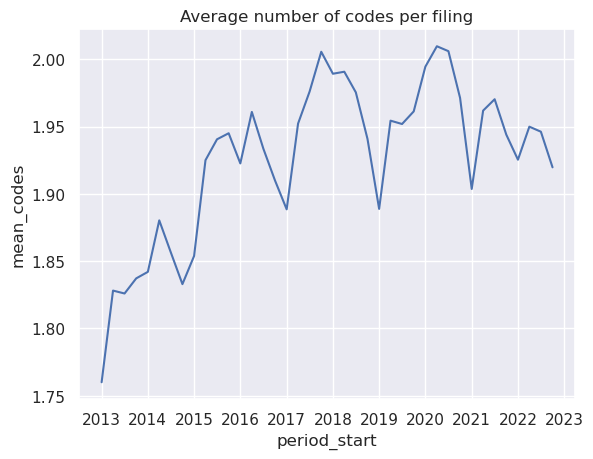

In [34]:
all_totals["mean_codes"] = lobbying_train.groupby("period_start")["num_codes"].mean()
all_totals["num_filings"] = lobbying_train.groupby("period_start")["num_codes"].count()
sns.lineplot(all_totals["mean_codes"])
plt.title("Average number of codes per filing");

But this is not enough variation to explain the yearly seasonality in individual normalized expenses series.

Text(0.5, 1.0, 'TAX expenses')

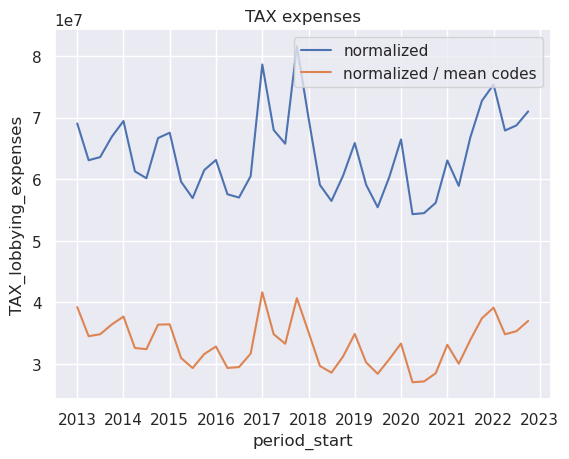

In [35]:
sns.lineplot(all_totals["TAX_lobbying_expenses"], label="normalized")
sns.lineplot(all_totals["TAX_lobbying_expenses"] / all_totals["mean_codes"], label="normalized / mean codes")
plt.title("TAX expenses")